In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image





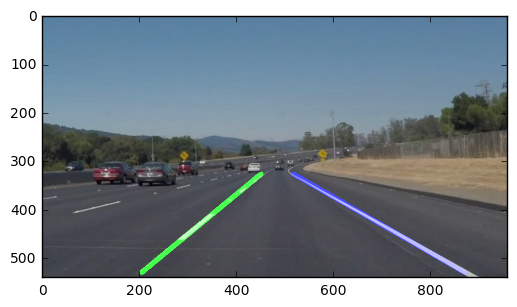

In [16]:

Img1=mpimg.imread('test_images/solidWhiteCurve.jpg')
Img2=mpimg.imread('test_images/solidWhiteRight.jpg')
Img3=mpimg.imread('test_images/solidYellowCurve.jpg')
Img4=mpimg.imread('test_images/solidYellowCurve2.jpg')
Img5=mpimg.imread('test_images/solidYellowLeft.jpg')
Img6=mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
#Get image sizes.
ySize=Img1.shape[0]
xSize=Img1.shape[1]

#Define vertices of the trapezoid for ROI
lBottom=[10,ySize-10]
rBottom=[xSize-10,ySize-10]
lTop=[(xSize/2+40),(ySize/1.65)];
rTop=[xSize/2-40,ySize/1.65];
vertices = np.array([[lBottom,rBottom,lTop,(xSize/2-40,ySize/1.65)]],np.int32)

#Parameters for Gaussian and Canny
GaussKernel=7
EdgeLowThresh=100     #Lower Threshold




#2 Detect White lines on a copy of image
def detectWhite(Img):
    #Make a copy of image
    wSelect=np.copy(Img)
    #Apply ROI on image 
    maskedImg=region_of_interest(wSelect,[vertices])
    #Threshold Values for White
    rThresh=175
    gThresh=175
    bThresh=160
    #Bitwise OR to mask pixesl below white threshold
    wThresh=(maskedImg[:,:,0] < rThresh) | (maskedImg[:,:,1] < gThresh) | (maskedImg[:,:,2] < bThresh)
    #Black regions which are below white threshold
    wSelect[wThresh]=[0,0,0]
    wSelect=grayscale(wSelect)     
    return wSelect

#3 Detect Yellow lines on a copy of image
def detectYellow(Img):    
    #Convert to HSV as it is easier to detect yellow in HSV colorspace
    hsvImg=cv2.cvtColor(Img,cv2.COLOR_RGB2HSV)
    #Apply ROI on image 
    maskedImg=region_of_interest(hsvImg,[vertices])
    #Define yellow thresholds in HSV
    lowYellow  =np.array([5,45,50])
    upperYellow=np.array([50,255,255])
    #Apply Threshold for yellow
    ySelect=cv2.inRange(maskedImg,lowYellow,upperYellow) 
    return ySelect

#4 Apply Gaussian and Canny Filter
def GaussCanny(Img):
    #Convert image into Gray
    GrayImg=grayscale(Img)      
    #Blur image with Gaussian Blur
    BlurredImg=gaussian_blur(GrayImg,GaussKernel)
    #Apply Canny Filter for edge detection
    EdgeImg=canny(BlurredImg,EdgeLowThresh,EdgeLowThresh*2)
    #Apply ROI masking to Edge detected image
    maskedImg=region_of_interest(EdgeImg,[vertices])
    return maskedImg

#5 BitWise OR all the images to form a composite
def FuseImgs(wImg,yImg,GCImg):
    wyImg=cv2.bitwise_or(wImg,yImg)
    wyGCImg=cv2.bitwise_or(wyImg,GCImg)    
    return wyGCImg
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):    
    #Different color  lanes for debug 
    LeftColor=[0,255,0]
    RightColor=[0,0,255]
    Lm=[] #Accumulator for Left slope
    Rm=[] #Accumulator for Right slope 
    Rx=[] #Container for all Right Xs
    Lx=[] #Container for all Left Xs
    Ry=[] #Container for all Right Ys
    Ly=[] #Container for all Left Ys
    if lines is None:
        return
    else:
        for line in lines:
            for x1,y1,x2,y2 in line:
                #Calculate slope of the line
                m=(y2-y1)/(x2-x1)
                
                #Right if m>0 and Left if m<0
                #Left Lane
                if(m<0):
                    Lm.append(m)
                    #Getting all Xs                    
                    Lx.append(x1)
                    Lx.append(x2)
                    #Getting all Ys
                    Ly.append(y1)
                    Ly.append(y2)
                #Right Lane
                if(m>0):
                    Rm.append(m)
                    #Getting all Xs
                    Rx.append(x1)
                    Rx.append(x2)
                    #Getting all Ys
                    Ry.append(y1)
                    Ry.append(y2)
                
        #Min and Max of Y        
        ymin=min(min(Ry),min(Ly))
        ymax=max(max(Ry),max(Ry))
        
        #Right Lane                
        AvgRm=sum(Rm)/len(Rm)   #Average Right Slope
        AvgRx=sum(Rx)/len(Rx)   #Average Right X
        AvgRy=sum(Ry)/len(Ry)   #Average Right Y
        Ryint=AvgRy-AvgRx*AvgRm #Y intercept of the line
        Rx1=int((ymin-Ryint)/AvgRm)
        Rx2=int((ymax-Ryint)/AvgRm)
        #Draw Right lane
        cv2.line(img,(Rx1,ymin),(Rx2,ymax),RightColor,thickness)
        
        #Left Lane
        AvgLm=sum(Lm)/len(Lm)   #Average Left Slope
        AvgLx=sum(Lx)/len(Lx)   #Average Right X
        AvgLy=sum(Ly)/len(Ly)   #Average Right Y
        Lyint=AvgLy-AvgLx*AvgLm #Y intercept of the line
        Lx1=int((ymin-Lyint)/AvgLm)
        Lx2=int((ymax-Lyint)/AvgLm)
        #Draw Right lane
        cv2.line(img,(Lx1,ymin),(Lx2,ymax),LeftColor,thickness)        
                    
                
                
#Parameters for Hough Transform
rho = 2               # distance resolution in pixels of the Hough grid
theta = 1*(np.pi/180) # angular resolution in radians of the Hough grid
threshold = 30        # minimum number of votes (intersections in Hough grid cell)
min_line_len = 20     #minimum number of pixels making up a line; Lower more lines
max_line_gap = 20     # maximum gap in pixels between connectable line segments; Lower more lines
                
                
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):   
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    
    return cv2.addWeighted(initial_img, α, img, β, λ)
#6 Apply HoughLine transform and then draw lines to indicate Lane Markings
def FindLane(FusedImg,OrigImg):
    hImg=hough_lines(FusedImg, rho, theta, threshold, min_line_len, max_line_gap)
    finalImg=weighted_img(hImg,OrigImg)
    return finalImg

#Final function which takes a color image and returns back image with Lanes marked
def process_image(Img):
    w=detectWhite(Img)
    y=detectYellow(Img)
    GC=GaussCanny(Img)
    Fused=FuseImgs(w,y,GC)
    result=FindLane(Fused,Img)
    return result
plt.imshow(process_image(Img1))

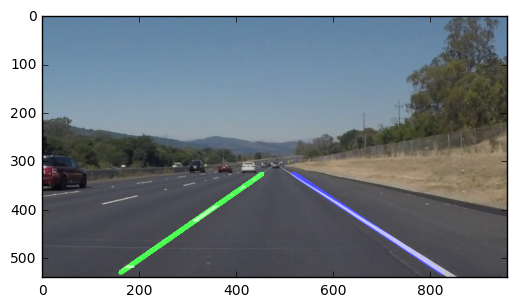

In [17]:
plt.imshow(process_image(Img2))

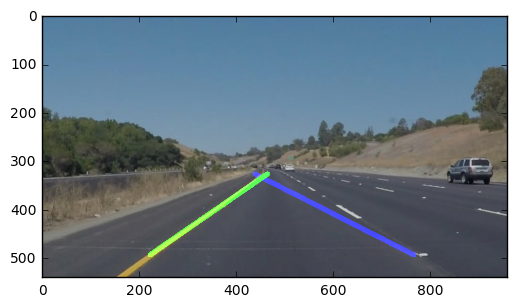

In [18]:
plt.imshow(process_image(Img3))

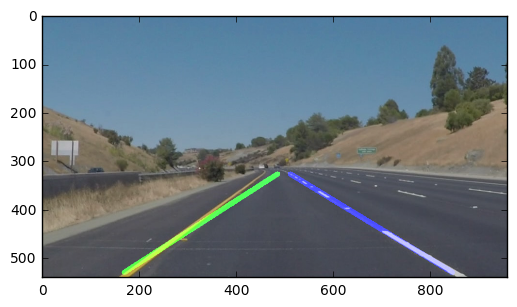

In [19]:
plt.imshow(process_image(Img4))

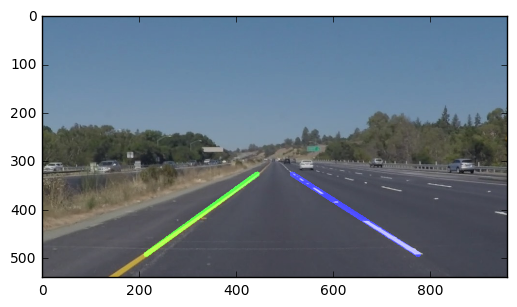

In [20]:
plt.imshow(process_image(Img5))

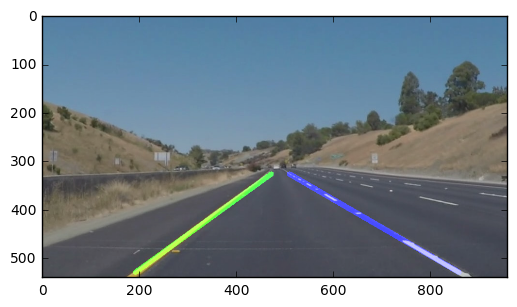

In [21]:
plt.imshow(process_image(Img6))

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

whiteOpt='White.mp4'
clip1=VideoFileClip("solidWhiteRight.mp4")
white_clip=clip1.fl_image(process_image)
%time white_clip.write_videofile(whiteOpt, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(whiteOpt))

[MoviePy] >>>> Building video White.mp4
[MoviePy] Writing video White.mp4


100%|███████████████████████████████████████▊| 221/222 [00:07<00:00, 36.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: White.mp4 

Wall time: 7.3 s
